In [33]:
import matplotlib.pyplot as plt
import numpy as np
import torch
import torchvision.transforms.functional as F

plt.rcParams["savefig.bbox"] = "tight"


In [34]:
def plot(imgs, **imshow_kwargs):
    if not isinstance(imgs[0], list):
        # Make a 2d grid even if there's just 1 row
        imgs = [imgs]

    num_rows = len(imgs)
    num_cols = len(imgs[0])
    _, axs = plt.subplots(nrows=num_rows, ncols=num_cols, squeeze=False)
    for row_idx, row in enumerate(imgs):
        for col_idx, img in enumerate(row):
            ax = axs[row_idx, col_idx]
            img = F.to_pil_image(img.to("cpu"))
            ax.imshow(np.asarray(img), **imshow_kwargs)
            ax.set(xticklabels=[], yticklabels=[], xticks=[], yticks=[])

    plt.tight_layout()


### デモ

In [144]:
import tempfile
from pathlib import Path
from urllib.request import urlretrieve

video_url = "https://download.pytorch.org/tutorial/pexelscom_pavel_danilyuk_basketball_hd.mp4"
video_path = Path(tempfile.mkdtemp()) / "basketball.mp4"
_ = urlretrieve(video_url, video_path)


/home/marumarukun/pj/compe/atma_18/.venv/lib/python3.12/site-packages/torchvision/io/video.py:161: UserWarning: The pts_unit 'pts' gives wrong results. Please use pts_unit 'sec'.
  warnings.warn("The pts_unit 'pts' gives wrong results. Please use pts_unit 'sec'.")


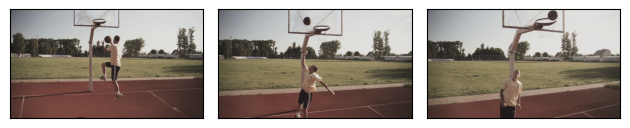

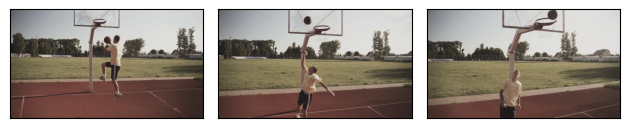

In [145]:
from torchvision.io import read_video

frames, _, _ = read_video(str(video_path), output_format="TCHW")

img1_batch = torch.stack([frames[100], frames[150], frames[200]])
img2_batch = torch.stack([frames[101], frames[151], frames[201]])

plot(img1_batch)
plot(img2_batch)


In [39]:
print(video_path)


/tmp/tmpw53_8cxk/basketball.mp4


In [40]:
from torchvision.models.optical_flow import Raft_Large_Weights

weights = Raft_Large_Weights.DEFAULT
transforms = weights.transforms()


def preprocess(img1_batch, img2_batch):
    img1_batch = F.resize(img1_batch, size=[520, 960], antialias=False)
    img2_batch = F.resize(img2_batch, size=[520, 960], antialias=False)
    return transforms(img1_batch, img2_batch)


img1_batch, img2_batch = preprocess(img1_batch, img2_batch)

print(f"shape = {img1_batch.shape}, dtype = {img1_batch.dtype}")


shape = torch.Size([3, 3, 520, 960]), dtype = torch.float32


In [41]:
from torchvision.models.optical_flow import raft_large

# If you can, run this example on a GPU, it will be a lot faster.
device = "cuda" if torch.cuda.is_available() else "cpu"

model = raft_large(weights=Raft_Large_Weights.DEFAULT, progress=False).to(device)
model = model.eval()

list_of_flows = model(img1_batch.to(device), img2_batch.to(device))
print(f"type = {type(list_of_flows)}")
print(f"length = {len(list_of_flows)} = number of iterations of the model")


type = <class 'list'>
length = 12 = number of iterations of the model


In [42]:
predicted_flows = list_of_flows[-1]
print(f"dtype = {predicted_flows.dtype}")
print(f"shape = {predicted_flows.shape} = (N, 2, H, W)")
print(f"min = {predicted_flows.min()}, max = {predicted_flows.max()}")


dtype = torch.float32
shape = torch.Size([3, 2, 520, 960]) = (N, 2, H, W)
min = -3.899388551712036, max = 6.399685859680176


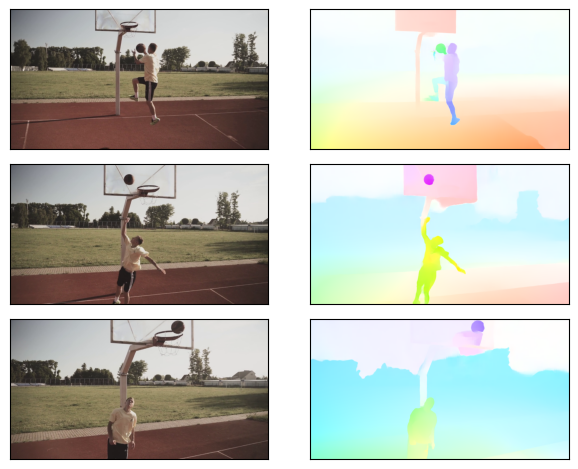

In [43]:
from torchvision.utils import flow_to_image

flow_imgs = flow_to_image(predicted_flows)

# The images have been mapped into [-1, 1] but for plotting we want them in [0, 1]
img1_batch = [(img1 + 1) / 2 for img1 in img1_batch]

grid = [[img1, flow_img] for (img1, flow_img) in zip(img1_batch, flow_imgs, strict=False)]
plot(grid)


### 実データに適用してみる

In [168]:
import albumentations as A
import cv2
from albumentations.pytorch import ToTensorV2

id_name = "80b2826eeefb2eaad8ab33b0c30620e7_220"
frame_1 = cv2.imread(f"../../data/input/images/{id_name}/image_t-1.0.png")
frame_1 = cv2.cvtColor(frame_1, cv2.COLOR_BGR2RGB)
frame_2 = cv2.imread(f"../../data/input/images/{id_name}/image_t-0.5.png")
frame_2 = cv2.cvtColor(frame_2, cv2.COLOR_BGR2RGB)
frame_3 = cv2.imread(f"../../data/input/images/{id_name}/image_t.png")
frame_3 = cv2.cvtColor(frame_3, cv2.COLOR_BGR2RGB)

transform = A.Compose(
    [
        # A.Resize(height=128, width=256),
        # A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
        ToTensorV2(),
    ]
)

frame_1 = transform(image=frame_1)["image"]
frame_2 = transform(image=frame_2)["image"]
frame_3 = transform(image=frame_3)["image"]

img1_batch = torch.stack([frame_1, frame_2])
img2_batch = torch.stack([frame_2, frame_3])


shape = torch.Size([2, 3, 64, 128]), dtype = torch.uint8


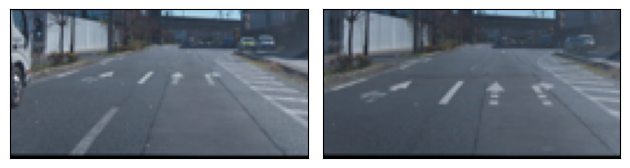

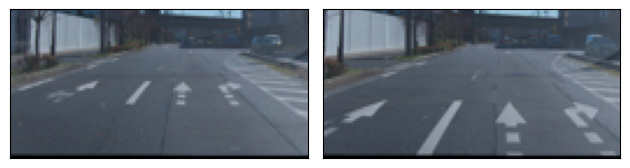

In [169]:
plot(img1_batch)
plot(img2_batch)

print(f"shape = {img1_batch.shape}, dtype = {img1_batch.dtype}")


In [170]:
from torchvision.models.optical_flow import Raft_Large_Weights

weights = Raft_Large_Weights.DEFAULT
transforms = weights.transforms()


def preprocess(img1_batch, img2_batch):
    img1_batch = F.resize(img1_batch, size=[128, 256], antialias=False)
    img2_batch = F.resize(img2_batch, size=[128, 256], antialias=False)
    return transforms(img1_batch, img2_batch)


img1_batch, img2_batch = preprocess(img1_batch, img2_batch)

print(f"shape = {img1_batch.shape}, dtype = {img1_batch.dtype}")


shape = torch.Size([2, 3, 128, 256]), dtype = torch.float32


In [171]:
from torchvision.models.optical_flow import raft_large

# If you can, run this example on a GPU, it will be a lot faster.
device = "cuda" if torch.cuda.is_available() else "cpu"

model = raft_large(weights=Raft_Large_Weights.DEFAULT, progress=False).to(device)
model = model.eval()

list_of_flows = model(img1_batch.to(device), img2_batch.to(device))
print(f"type = {type(list_of_flows)}")
print(f"length = {len(list_of_flows)} = number of iterations of the model")


type = <class 'list'>
length = 12 = number of iterations of the model


In [172]:
predicted_flows = list_of_flows[-1]
print(f"dtype = {predicted_flows.dtype}")
print(f"shape = {predicted_flows.shape} = (N, 2, H, W)")
print(f"min = {predicted_flows.min()}, max = {predicted_flows.max()}")


dtype = torch.float32
shape = torch.Size([2, 2, 128, 256]) = (N, 2, H, W)
min = -73.71615600585938, max = 85.2684097290039


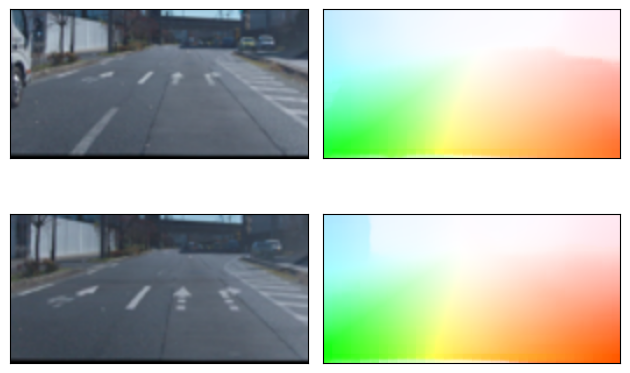

In [173]:
from torchvision.utils import flow_to_image

flow_imgs = flow_to_image(predicted_flows)

# The images have been mapped into [-1, 1] but for plotting we want them in [0, 1]
img1_batch = [(img1 + 1) / 2 for img1 in img1_batch]

grid = [[img1, flow_img] for (img1, flow_img) in zip(img1_batch, flow_imgs, strict=False)]
plot(grid)
